In [1]:
%matplotlib inline

import collections
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

from sklearn import grid_search
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC

In [2]:
# 2014-02-03T19:24:07Z
def parse_time(time):
    return datetime.datetime.strptime(time, '%Y-%m-%dT%H:%M:%SZ')

In [3]:
SECONDS_PER_DAY = 60 * 60 * 24
def days_between(start_date, end_date):
    return (parse_time(end_date) - parse_time(start_date)).total_seconds() / SECONDS_PER_DAY

In [4]:
print days_between('2014-01-03T19:24:07Z', '2014-02-03T19:24:07Z')

31.0


# Import Metadata and Remove Forks

In [4]:
selected_metadata_file = os.path.join('selected_metadata.txt')

ID_TO_LINK_MAP_PATH = os.path.join('..', 'data', 'id_to_link_map.json')

# Metadata parameters
METADATA_INDEX_PATH = os.path.join('..', 'data', 'metadata_index.json')
README_ID_INDEX = '0'
WATCH_INDEX = '1'
STAR_INDEX = '2'
FORK_INDEX = '3'
COMMIT_INDEX = '4'
BRANCH_INDEX = '5'
RELEASES_INDEX = '6'
CONTRIB_INDEX = '7'
LATEST_AUTHOR_INDEX = '8'
DESCRIPTION_INDEX = '9'
LATEST_README_INDEX = '10'
FIRST_README_INDEX = '11'

In [18]:
print 'Loading metadata.'
metadata_index = json.load(open(METADATA_INDEX_PATH))


print 'Loading id-to-link map.'
id_to_link_map = json.load(open(ID_TO_LINK_MAP_PATH))

all_ids = []
all_scores = []

print 'Calculating document scores.'
header = True
for line in open(selected_metadata_file):
    if header:
        header = False
        continue
    parts = line.strip().split()
    doc_id = parts[0]

    doc_score = 1

    if doc_id in metadata_index:
        doc_metadata = metadata_index[doc_id]
        if WATCH_INDEX in doc_metadata:
            doc_score *= np.log10(doc_metadata[WATCH_INDEX])
        if STAR_INDEX in doc_metadata:
            doc_score *= np.log10(doc_metadata[STAR_INDEX])
        if CONTRIB_INDEX in doc_metadata:
            doc_score *= np.log10(doc_metadata[CONTRIB_INDEX])
    
    all_ids.append( (doc_id, doc_score) )

all_ids.sort(reverse = True, key = lambda t: t[1])
print 'Total ids:', len(all_ids)
print '\t', all_ids[:5]


# Remove forked projects from results.
# Our assumption is that one repo is a fork of another if:
# 1. They have the same repo description (raw) and repo name (derived from url).

name_to_description = collections.defaultdict(set)

print 'Removing forks'
clean_ids = []
for t in all_ids:

    doc_id = t[0]
    if doc_id not in id_to_link_map:
        continue
        
    doc_url = id_to_link_map[doc_id]
    # Name is last part of the url.
    doc_name = doc_url.split('/')[-1].lower()

    add_to_clean = False
    # 1
    if not add_to_clean and doc_id in metadata_index:
        doc_metadata = metadata_index[doc_id]
        if DESCRIPTION_INDEX in doc_metadata:
            doc_description = doc_metadata[DESCRIPTION_INDEX]
            # Simple description normalization.
            if len(doc_description) > 0 and doc_description[-1] == '.':
                doc_description = doc_description[:-1]
            #
            if doc_description not in name_to_description[doc_name]:
                name_to_description[doc_name].add(doc_description)
                add_to_clean = True

    if add_to_clean:
         clean_ids.append(doc_id)

# Number of ids after cleaning
print 'Number of ids after cleaning:', len(clean_ids)            
            
print 'Dumping cleaned ids...'
json.dump(clean_ids, open(os.path.join('clean_ids.json'), 'w+'))

Loading metadata.
Loading id-to-link map.
Calculating document scores.
Total ids: 109284
	[('925608', 56.280203692020059), ('1752', 49.333310948199632), ('70403', 46.999755966372348), ('72644', 43.151584591348701), ('1031723', 38.364214516268987)]
Removing forks
Number of ids after cleaning: 106279
Dumping cleaned ids...


# Load Precomputed Clean IDs

In [5]:
clean_ids = json.load(open(os.path.join('clean_ids.json')))
clean_ids_set = set(clean_ids)

# Predict Lifespan Class

In [5]:
header = True
for line in open(selected_metadata):
    if header:
        header = False
        continue
    parts = line.strip().split()
    doc_id = parts[0]
    between = days_between(parts[2], parts[3])
    meta_days_between.append(between)
    
    for class_label, upper_bound in enumerate(class_upper_bounds):
        if between <= upper_bound:
            class_buckets[class_label].append( (doc_id, parts[2], parts[3]) )
            break
    
meta_days_between = [m for m in meta_days_between if m >= 0]
print len(meta_days_between)

108966


(array([  8.06830000e+04,   1.03880000e+04,   6.01400000e+03,
          3.86200000e+03,   2.31600000e+03,   1.56100000e+03,
          1.10500000e+03,   8.14000000e+02,   6.02000000e+02,
          3.66000000e+02,   3.16000000e+02,   1.78000000e+02,
          1.25000000e+02,   9.70000000e+01,   9.30000000e+01,
          7.80000000e+01,   5.70000000e+01,   6.20000000e+01,
          6.30000000e+01,   4.70000000e+01,   2.20000000e+01,
          1.80000000e+01,   1.30000000e+01,   7.00000000e+00,
          1.20000000e+01,   5.00000000e+00,   9.00000000e+00,
          9.00000000e+00,   3.00000000e+00,   9.00000000e+00,
          6.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   4.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
        

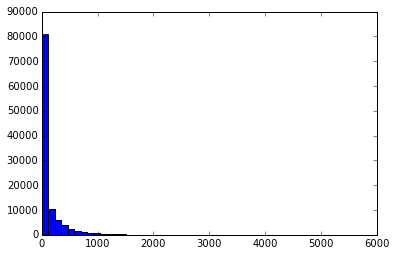

In [6]:
plt.hist(meta_days_between, bins = 50)

In [7]:
total = 0
for i in range(NUM_CLASSES):
    total += len(class_buckets[i])
    print i, len(class_buckets[i])
print 'Total:', total

0 66055
1 6774
2 8615
3 16607
4 11233
Total: 109284


## Import READMEs

In [8]:
readmes = []
classes = []

counter = 0

for c in range(NUM_CLASSES):
    for entry in class_buckets[c]:
        if parse_time(entry[1]).year != 2015:
            readme_path = os.path.join('data', 'clean', str(int(entry[0])/1000000) , entry[0] + '.md')
            try: # Some READMEs may have had no content after being cleaned.
                readme = ' '.join(open(readme_path).readlines())
                readmes.append( readme )
                classes.append(c)
            except:
                pass
        
        counter += 1
        if counter % 10000 == 0:
            print 'Progress:', counter

print 'Number of valid READMEs', len(readmes)

Progress: 10000
Progress: 20000
Progress: 30000
Progress: 40000
Progress: 50000
Progress: 60000
Progress: 70000
Progress: 80000
Progress: 90000
Progress: 100000
Number of valid READMEs 95000


In [23]:
vectorizer = CountVectorizer(ngram_range=(1,2))  # for  unigrams only use ngram_range=(1, 1)
readme_term_matrix = vectorizer.fit_transform(readmes)

In [26]:
matrix_train, matrix_test, classes_train, classes_test = \
    train_test_split(readme_term_matrix, classes, test_size=0.80, random_state=42)

## Estimator Using Only Text

In [27]:
parameter_grid = dict(
    estimator__C=[1e-2, 1e-1, 1, 1e1, 1e2],  # you can also build this using np.logspace
    estimator__class_weight=['auto', None])

clf = grid_search.GridSearchCV(OneVsRestClassifier(LinearSVC()), parameter_grid, cv=3, verbose=True)

In [28]:
clf.fit(matrix_train, classes_train) 

C:\Users\Joshua\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function multilabel_ is deprecated; Attribute multilabel_ is deprecated and will be removed in 0.17. Use 'y_type_.startswith('multilabel')' instead
  warnings.warn(msg, category=DeprecationWarning)
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:  2.6min
C:\Users\Joshua\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function multilabel_ is deprecated; Attribute multilabel_ is deprecated and will be removed in 0.17. Use 'y_type_.startswith('multilabel')' instead
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Joshua\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function multilabel_ is deprecated; Attribute multilabel_ is deprecated and will be removed in 0.17. Use 'y_type_.startswith('multilabel')' instead
  warnings.warn(msg, category=DeprecationWar

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3,
       estimator=OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0),
          n_jobs=1),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'estimator__class_weight': ['auto', None], 'estimator__C': [0.01, 0.1, 1, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=True)

In [29]:
predictions = clf.predict(matrix_test)

In [30]:
predictions_list = list(predictions)

In [31]:
print len(predictions), len(classes_test)

76000 76000


In [36]:
errors = 0

class_errors = collections.defaultdict(int)

for actual, pred in zip(classes_test, predictions_list):
    if actual != pred:
        errors += 1
        class_errors[actual] += 1
        
print 'Number of errors:', errors
print 'Error Percentage', errors * 100.0 / len(predictions_list) , '%'

print '====='
for c in range(NUM_CLASSES):
    print c, class_errors[c], class_errors[c] * 100.0 / list(classes_test).count(c)

Number of errors: 35350
Error Percentage 46.5131578947 %
=====
0 6018 13.8227254979
1 3961 98.166047088
2 5941 96.0084033613
3 11568 86.990524891
4 7862 87.9221650637


## Estimator Using Google Trends

# Predict Latest Commit Date

In [9]:
class_buckets = collections.defaultdict(list)

header = True
for line in open(selected_metadata_file):
    if header:
        header = False
        continue
    parts = line.strip().split()
    doc_id = parts[0]
    
    if doc_id not in clean_ids_set:
        continue
    
    latest_commit = parse_time(parts[3])

    class_buckets[latest_commit.year].append(doc_id)

In [10]:
print 'Year\tAmount'
for k in class_buckets:
    if k > 2007:
        print k, '\t', len(class_buckets[k])

print '\n\n'
print class_buckets[2008][:10]

Year	Amount
2008 	597
2009 	1777
2010 	841
2011 	4054
2012 	8991
2013 	17818
2014 	43932
2015 	28231



['6', '10', '28', '31', '36', '39', '44', '45', '80', '93']


In [24]:
readmes = []
classes = []

counter = 0

for k in class_buckets:
    if k > 2007:
        for entry in class_buckets[k]:
            readme_path = os.path.join('..', 'data', 'clean', str(int(entry)/1000000) , entry + '.md')
            try: # Some READMEs may have had no content after being cleaned.
                readme = ' '.join(open(readme_path).readlines())
                readmes.append( readme )
                #if os.path.isfile(readme_path):
                #    classes.append(k)
            except:
                pass
        
            counter += 1
            if counter % 10000 == 0:
                print 'Progress:', counter

print 'Number of valid READMEs', len(readmes)

Progress: 10000
Progress: 20000
Progress: 30000
Progress: 40000
Progress: 50000
Progress: 60000
Progress: 70000
Progress: 80000
Progress: 90000
Progress: 100000
Number of valid READMEs 106241


In [25]:
vectorizer = CountVectorizer(ngram_range=(1,2), max_df=0.6, min_df=2)  # for  unigrams only use ngram_range=(1, 1)
readme_term_matrix = vectorizer.fit_transform(readmes)

In [26]:
print readme_term_matrix.shape

(106241, 1932418)


### Save readme_term_matrix

In [26]:
print readme_term_matrix.shape
pickle.dump(readme_term_matrix, open('readme_term_matrix.p', 'w+'))

(106241, 8550277)


### Load readme_term_matrix

In [6]:
# (106241, 8550277)
readme_term_matrix = pickle.load(open('readme_term_matrix.p'))
print readme_term_matrix.shape

(106241, 8550277)


## Split into training/test data

In [21]:
matrix_train, matrix_test, classes_train, classes_test = \
    train_test_split(readme_term_matrix, classes, test_size=0.20, random_state=42)

In [15]:
def test_classifier(clf, clf_name, matrix_train, classes_train, matrix_test, classes_test):
    clf.fit(matrix_train, classes_train)

    multi_nb_predictions = clf.predict(matrix_test)

    errors = 0

    class_errors = collections.defaultdict(int)

    for actual, pred in zip(classes_test, multi_nb_predictions):
        if actual != pred:
            errors += 1
            class_errors[actual] += 1

    print 'Classifier:', clf_name
    print 'Number of training examples:', matrix_train.shape[0]
    print 'Number of test examples:', matrix_test.shape[0]
    print 'Number of errors:', errors
    print 'Error Percentage', errors * 100.0 / len(multi_nb_predictions) , '%'

    print '====='
    print 'Year\tAmount\tError %'
    for c in class_errors:
        print c, '\t', class_errors[c], '\t', class_errors[c] * 100.0 / list(classes_test).count(c), '%'

### Multinomial Bayes

In [31]:
clf = MultinomialNB()
test_classifier(clf, 'MultinomialNB', matrix_train, classes_train, matrix_test, classes_test)

Classifier: MultinomialNB
Number of training examples: 84992
Number of test examples: 21249
Number of errors: 12629
Error Percentage 59.4333851005 %
=====
Year	Amount	Error %
2008 	132 	100.0 %
2009 	362 	99.7245179063 %
2010 	177 	100.0 %
2011 	792 	99.7481108312 %
2012 	1790 	98.0284775465 %
2013 	3334 	94.3941109853 %
2014 	3568 	40.2481669487 %
2015 	2474 	44.4964028777 %


### Linear SVC

In [14]:
#clf = LinearSVC()
#test_classifier(clf, 'LinearSVC', matrix_train, classes_train, matrix_test, classes_test)
print 'Classifier: OvR(LinearSVC)'

Classifier: OvR(LinearSVC)


### Random Forest

In [ ]:
clf = KNeighborsClassifier()
test_classifier(clf, 'KNeighborsClassifier', matrix_train, classes_train, matrix_test, classes_test)

### Multinomial Bayes OvR

In [32]:
clf = OneVsRestClassifier(MultinomialNB())
test_classifier(clf, 'OvR(MultinomialNB)', matrix_train, classes_train, matrix_test, classes_test)

Classifier: OvR(MultinomialNB)
Number of training examples: 84992
Number of test examples: 21249
Number of errors: 12869
Error Percentage 60.5628500165 %
=====
Year	Amount	Error %
2008 	130 	98.4848484848 %
2009 	361 	99.4490358127 %
2010 	177 	100.0 %
2011 	788 	99.2443324937 %
2012 	1765 	96.6593647317 %
2013 	3239 	91.704416761 %
2014 	3919 	44.2075578116 %
2015 	2490 	44.7841726619 %


In [27]:
clf = MultinomialNB()
test_classifier(clf, 'MultinomialNB', matrix_train, classes_train, matrix_test, classes_test)

Classifier: MultinomialNB
Number of training examples: 84992
Number of test examples: 21249
Number of errors: 12629
Error Percentage 59.4333851005 %
=====
Year	Amount	Error %
2008 	132 	100.0 %
2009 	362 	99.7245179063 %
2010 	177 	100.0 %
2011 	792 	99.7481108312 %
2012 	1790 	98.0284775465 %
2013 	3334 	94.3941109853 %
2014 	3568 	40.2481669487 %
2015 	2474 	44.4964028777 %


In [28]:
clf = OneVsRestClassifier(MultinomialNB())
test_classifier(clf, 'OvR(MultinomialNB)', matrix_train, classes_train, matrix_test, classes_test)

Classifier: OvR(MultinomialNB)
Number of training examples: 84992
Number of test examples: 21249
Number of errors: 12869
Error Percentage 60.5628500165 %
=====
Year	Amount	Error %
2008 	130 	98.4848484848 %
2009 	361 	99.4490358127 %
2010 	177 	100.0 %
2011 	788 	99.2443324937 %
2012 	1765 	96.6593647317 %
2013 	3239 	91.704416761 %
2014 	3919 	44.2075578116 %
2015 	2490 	44.7841726619 %
